# Boosted Analysis

In [1]:
from kepler.pandas.menu       import ElectronSequence as Chain
from kepler.pandas.readers    import load, load_in_loop, load_hdf
from kepler.pandas.decorators import RingerDecorator
from core import Efficiency, restore_efficiencies
from Gaugi import mkdir_p, progressbar
import numpy as np
import pandas as pd
import collections
import os
import array
import root_numpy
import rootplotlib as rpl
from pprint import pprint
from copy import deepcopy
import gc
from ROOT import kBlack,kBlue,kRed,kAzure,kGreen,kMagenta,kCyan,kOrange,kGray,kYellow,kWhite,TColor,gStyle,TCanvas,kBlackBody
import ROOT
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

Welcome to JupyROOT 6.16/00
Using all sub packages with ROOT dependence
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.

Applying ATLAS style settings...

Applying ATLAS style settings...

Applying ATLAS style settings...


In [2]:
os.getcwd()

'/home/jodafons/git_repos/ringer/run/jodafons/notebooks/Run2/2021'

In [3]:
output_path = 'output/boosted'
mkdir_p(output_path)

In [4]:
drop_columns = [
                    #'RunNumber', 
                    #'avgmu',
                    #'trig_L2_cl_et',
                    #'trig_L2_cl_eta',
                    #'trig_L2_cl_phi',
                    #'trig_L2_cl_reta',
                    #'trig_L2_cl_ehad1', 
                    #'trig_L2_cl_eratio',
                    #'trig_L2_cl_f1', 
                    #'trig_L2_cl_f3', 
                    #'trig_L2_cl_weta2', 
                    #'trig_L2_cl_wstot', 
                    'trig_L2_cl_e2tsts1',
                    'trig_L2_el_hastrack',
                    'trig_L2_el_pt',
                    'trig_L2_el_eta',
                    'trig_L2_el_phi',
                    'trig_L2_el_caloEta',
                    'trig_L2_el_trkClusDeta',
                    'trig_L2_el_trkClusDphi',
                    'trig_L2_el_etOverPt',
                    'trig_EF_cl_hascluster',
                    #'trig_EF_cl_et',
                    'trig_EF_cl_eta',
                    'trig_EF_cl_etaBE2',
                    'trig_EF_cl_phi',     
                    'trig_EF_el_hascand',
                    #'trig_EF_el_et',
                    'trig_EF_el_eta',
                    'trig_EF_el_etaBE2',
                    'trig_EF_el_phi',
                    'trig_EF_el_rhad1',
                    'trig_EF_el_rhad',
                    'trig_EF_el_f3',
                    'trig_EF_el_weta2',
                    'trig_EF_el_rphi',
                    'trig_EF_el_reta',
                    'trig_EF_el_wtots1',
                    'trig_EF_el_eratio',
                    'trig_EF_el_f1',
                    'trig_EF_el_hastrack',
                    'trig_EF_el_deltaEta1',
                    'trig_EF_el_deltaPhi2',
                    'trig_EF_el_deltaPhi2Rescaled',
                    #'trig_EF_el_lhtight',
                    #'trig_EF_el_lhmedium',
                    #'trig_EF_el_lhloose',
                    #'trig_EF_el_lhvloose', 
                    # Offline variables
                    #'el_et',
                    #'el_eta',
                    'el_etaBE2',
                    #'el_phi',
                    # offline shower shapers
                    #'el_rhad1',
                    #'el_rhad',
                    #'el_f3',
                    #'el_weta2',
                    #'el_rphi',
                    #'el_reta',
                    #'el_wtots1',
                    #'el_eratio',
                    #'el_f1',
                    # offline track
                    #'el_hastrack',
                    'el_numberOfBLayerHits',
                    'el_numberOfPixelHits',
                    'el_numberOfTRTHits',
                    #'el_d0',
                    #'el_d0significance',
                    #'el_eProbabilityHT',
                    'el_trans_TRT_PID',
                    #'el_deltaEta1',
                    'el_deltaPhi2',
                    #'el_deltaPhi2Rescaled',
                    #'el_deltaPOverP',
                    #'el_lhtight',
                    #'el_lhmedium',
                    #'el_lhloose',
                    #'el_lhvloose',
                    'el_TaP_Mass',
                    #'el_TaP_deltaR',
                ] 

drop_columns.extend( ['trig_L2_cl_ring_%d'%i for i in range(100)] )

In [5]:
def load_in_loop( paths, drop_columns ):
    tables = []
    for path in progressbar( paths, prefix='Reading files...'):
        df = load_hdf( path )
        df.drop( drop_columns, axis=1, inplace=True )    
        tables.append(df)
    return pd.concat(tables).reset_index(drop=True)

In [6]:
dpath = '/home/jodafons/public/cern_data/new_files/mc16_13TeV.309995.sgn.boosted_probes.GGF_radion_ZZ_llqq.merge.25bins.v3'
dpath+= '/mc16_13TeV.309995.sgn.boosted_probes.GGF_radion_ZZ_llqq.merge.25bins.v3_et{ET}_eta{ETA}.h5'
paths = []
for et in [4]:
    for eta in range(5):
        paths.append( dpath.format(ET=et,ETA=eta) )
my_df = load_in_loop(paths, drop_columns)

Reading files...: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


## Decorator:

In [7]:
def generator_v8( df ):
    columns= ['trig_L2_cl_ring_%d'%i for i in range(100)]
    rings = df[columns].values.astype(np.float32)
    def norm1( data ):
        norms = np.abs( data.sum(axis=1) )
        norms[norms==0] = 1
        return data/norms[:,None]
    rings = norm1(rings)
    return [rings]

def generator_v12( df ):

    
    # for new training, we selected 1/2 of rings in each layer
    #pre-sample - 8 rings
    # EM1 - 64 rings
    # EM2 - 8 rings
    # EM3 - 8 rings
    # Had1 - 4 rings
    # Had2 - 4 rings
    # Had3 - 4 rings
    prefix = 'trig_L2_cl_ring_%i'

    # rings presmaple 
    presample = [prefix %iring for iring in range(8//2)]
    # EM1 list
    sum_rings = 8
    em1 = [prefix %iring for iring in range(sum_rings, sum_rings+(64//2))]
    # EM2 list
    sum_rings = 8+64
    em2 = [prefix %iring for iring in range(sum_rings, sum_rings+(8//2))]
    # EM3 list
    sum_rings = 8+64+8
    em3 = [prefix %iring for iring in range(sum_rings, sum_rings+(8//2))]
    # HAD1 list
    sum_rings = 8+64+8+8
    had1 = [prefix %iring for iring in range(sum_rings, sum_rings+(4//2))]
    # HAD2 list
    sum_rings = 8+64+8+8+4
    had2 = [prefix %iring for iring in range(sum_rings, sum_rings+(4//2))]
    # HAD3 list
    sum_rings = 8+64+8+8+4+4
    had3 = [prefix %iring for iring in range(sum_rings, sum_rings+(4//2))]
    col_names = presample+em1+em2+em3+had1+had2+had3
    rings = df[col_names].values.astype(np.float32)

    def norm1( data ):
        norms = np.abs( data.sum(axis=1) )
        norms[norms==0] = 1
        return data/norms[:,None]
    
    target = df['target'].values.astype(np.int16)
    data_rings = norm1(rings)
    avgmu = df.avgmu.values
  
    return [data_rings]


def generator_v2_el(df):
    
    # for new training, we selected 1/2 of rings in each layer
    #pre-sample - 8 rings
    # EM1 - 64 rings
    # EM2 - 8 rings
    # EM3 - 8 rings
    # Had1 - 4 rings
    # Had2 - 4 rings
    # Had3 - 4 rings
    prefix = 'trig_L2_cl_ring_%i'

    # rings presmaple 
    presample = [prefix %iring for iring in range(8//2)]
    # EM1 list
    sum_rings = 8
    em1 = [prefix %iring for iring in range(sum_rings, sum_rings+(64//2))]
    # EM2 list
    sum_rings = 8+64
    em2 = [prefix %iring for iring in range(sum_rings, sum_rings+(8//2))]
    # EM3 list
    sum_rings = 8+64+8
    em3 = [prefix %iring for iring in range(sum_rings, sum_rings+(8//2))]
    # HAD1 list
    sum_rings = 8+64+8+8
    had1 = [prefix %iring for iring in range(sum_rings, sum_rings+(4//2))]
    # HAD2 list
    sum_rings = 8+64+8+8+4
    had2 = [prefix %iring for iring in range(sum_rings, sum_rings+(4//2))]
    # HAD3 list
    sum_rings = 8+64+8+8+4+4
    had3 = [prefix %iring for iring in range(sum_rings, sum_rings+(4//2))]
    col_names = presample+em1+em2+em3+had1+had2+had3
    rings = df[col_names].values.astype(np.float32)

    def norm1( data ):
        norms = np.abs( data.sum(axis=1) )
        norms[norms==0] = 1
        return data/norms[:,None]
    
    target = df['target'].values.astype(np.int16)
    data_rings = norm1(rings)
    avgmu = df.avgmu.values

    n = data_rings.shape[0]
    data_etOverPt = df['trig_L2_el_etOverPt'].astype(np.float32).to_numpy().reshape((n,1))  / 1
    data_deta     = df['trig_L2_el_trkClusDeta'].astype(np.float32).to_numpy().reshape((n,1))  / 1.
    data_dphi     = df['trig_L2_el_trkClusDphi'].astype(np.float32).to_numpy().reshape((n,1))  / 1.
    data_trk    = np.concatenate( (data_etOverPt, data_deta, data_dphi), axis=1)
 
    return [data_rings, data_trk]

In [8]:
os.getcwd()

'/home/jodafons/git_repos/ringer/run/jodafons/notebooks/Run2/2021'

In [9]:
tpath = 'v8/output/fitting'
decorators = [
    RingerDecorator('ringer_v8_tight' , tpath + '/ElectronRingerTightTriggerConfig.conf'    , generator_v8),
    RingerDecorator('ringer_v8_medium', tpath + '/ElectronRingerMediumTriggerConfig.conf'   , generator_v8),
    RingerDecorator('ringer_v8_loose' , tpath + '/ElectronRingerLooseTriggerConfig.conf'    , generator_v8),
    RingerDecorator('ringer_v8_vloose', tpath + '/ElectronRingerVeryLooseTriggerConfig.conf', generator_v8),
]
tpath = 'v12/output/fitting'
decorators.extend( [
    RingerDecorator('ringer_v12_tight' , tpath + '/ElectronRingerTightTriggerConfig.conf'    , generator_v12),
    RingerDecorator('ringer_v12_medium', tpath + '/ElectronRingerMediumTriggerConfig.conf'   , generator_v12),
    RingerDecorator('ringer_v12_loose' , tpath + '/ElectronRingerLooseTriggerConfig.conf'    , generator_v12),
    RingerDecorator('ringer_v12_vloose', tpath + '/ElectronRingerVeryLooseTriggerConfig.conf', generator_v12),
] )

tpath = 'v2_el/output/fitting'
decorators.extend( [
    RingerDecorator('ringer_v2_el_loose' , tpath + '/ElectronRingerLooseTriggerConfig.conf'    , generator_v2_el),
] )

2022-03-29 00:05:40,951 | Py.RingerDecorator                      INFO Reading... v8/output/fitting/ElectronRingerTightTriggerConfig.conf
2022-03-29 00:05:42,632 | Py.RingerDecorator                      INFO Reading... v8/output/fitting/ElectronRingerMediumTriggerConfig.conf
2022-03-29 00:05:43,555 | Py.RingerDecorator                      INFO Reading... v8/output/fitting/ElectronRingerLooseTriggerConfig.conf
2022-03-29 00:05:44,417 | Py.RingerDecorator                      INFO Reading... v8/output/fitting/ElectronRingerVeryLooseTriggerConfig.conf
2022-03-29 00:05:44,993 | Py.RingerDecorator                      INFO Reading... v12/output/fitting/ElectronRingerTightTriggerConfig.conf
2022-03-29 00:05:45,619 | Py.RingerDecorator                      INFO Reading... v12/output/fitting/ElectronRingerMediumTriggerConfig.conf
2022-03-29 00:05:46,316 | Py.RingerDecorator                      INFO Reading... v12/output/fitting/ElectronRingerLooseTriggerConfig.conf
2022-03-29 00:05:47,098 |

In [10]:
def load_in_loop( paths, decorators ):

    tables = []
    for path in progressbar( paths, prefix='Reading files...'):
        df = load_hdf( path )
        hold_these_columns = []
        for decorator in decorators:
            decorator.apply(df) 
            hold_these_columns.append(decorator.column)
            hold_these_columns.append(decorator.column + '_output')
            
        tables.append(df[hold_these_columns])

    return pd.concat(tables).reset_index(drop=True)


In [20]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
my_dec_df = load_in_loop( paths, decorators )

Reading files...: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


In [21]:
my_data = pd.concat( (my_df, my_dec_df), axis=1 )

In [22]:
# create my chain

versions = ['v8', 'v12']

chains = [
    Chain( "HLT_e17_lhvloose_nod0_noringer_L1EM15VHI", L1Seed = 'L1_EM15VHI' ),
    Chain( "HLT_e28_lhtight_nod0_noringer_ivarloose", L1Seed = 'L1_EM22VHI' ),
    Chain( "HLT_e60_lhmedium_nod0_noringer_L1EM24VHI", L1Seed = 'L1_EM24VHI' ),
    Chain( "HLT_e140_lhloose_nod0_noringer" , L1Seed = 'L1_EM24VHI' ), 
    Chain( "HLT_e17_lhvloose_nod0_ringer_v17_L1EM15VHI"    , L1Seed = 'L1_EM15VHI' , l2calo_column = 'ringer_v12_vloose',l2_column = 'ringer_v2_el_loose'),
    Chain( "HLT_e28_lhtight_nod0_ringer_v17_ivarloose"     , L1Seed = 'L1_EM22VHI' , l2calo_column = 'ringer_v12_tight' ,l2_column = 'ringer_v2_el_loose'),
    Chain( "HLT_e60_lhmedium_nod0_ringer_v17_L1EM24VHI"    , L1Seed = 'L1_EM24VHI' , l2calo_column = 'ringer_v12_medium',l2_column = 'ringer_v2_el_loose'),
    Chain( "HLT_e140_lhloose_nod0_ringer_v17"              , L1Seed = 'L1_EM24VHI' , l2calo_column = 'ringer_v12_loose' ,l2_column = 'ringer_v2_el_loose'),
]

for v in versions:
    chains.extend(
    [
    Chain( "HLT_e17_lhvloose_nod0_ringer_%s_L1EM15VHI"%v, L1Seed = 'L1_EM15VHI' , 
          l2calo_column = 'ringer_%s_vloose'%v),
    Chain( "HLT_e28_lhtight_nod0_ringer_%s_ivarloose"%v, L1Seed = 'L1_EM22VHI' , 
          l2calo_column = 'ringer_%s_tight'%v),
    Chain( "HLT_e60_lhmedium_nod0_ringer_%s_L1EM24VHI"%v, L1Seed = 'L1_EM24VHI' , 
          l2calo_column = 'ringer_%s_medium'%v),
    Chain( "HLT_e140_lhloose_nod0_ringer_%s"%v , L1Seed = 'L1_EM24VHI', 
          l2calo_column = 'ringer_%s_loose'%v),
    ]
    )



def emulate( df ):
    for chain in progressbar(chains, prefix='Emulate...'):
        chain.apply(df)

OrderedDict([('L1Seed', 'L1_EM15VHI'),
             ('L2Calo', (14000.0, 'trig_L2_cl_vloose_et12to22')),
             ('L2', 'trig_L2_el_cut_pt15to20'),
             ('EFCalo', 17000.0),
             ('HLT', (17000.0, 'trig_EF_el_lhvloose'))])
OrderedDict([('L1Seed', 'L1_EM22VHI'),
             ('L2Calo', (25000.0, 'trig_L2_cl_tight_et22toInf')),
             ('L2', 'trig_L2_el_cut_pt20to50'),
             ('EFCalo', 28000.0),
             ('HLT', (28000.0, 'trig_EF_el_lhtight_ivarloose'))])
OrderedDict([('L1Seed', 'L1_EM24VHI'),
             ('L2Calo', (57000.0, 'trig_L2_cl_medium_et22toInf')),
             ('L2', 'trig_L2_el_cut_pt50toInf'),
             ('EFCalo', 60000.0),
             ('HLT', (60000.0, 'trig_EF_el_lhmedium'))])
OrderedDict([('L1Seed', 'L1_EM24VHI'),
             ('L2Calo', (137000.0, 'trig_L2_cl_loose_et22toInf')),
             ('L2', 'trig_L2_el_cut_pt50toInf'),
             ('EFCalo', 140000.0),
             ('HLT', (140000.0, 'trig_EF_el_lhloose'))])
OrderedDic

In [23]:
emulate(my_data)

Emulate...: 100%|██████████| 16/16 [00:00<00:00, 102.52it/s]


## Make Plots:

In [24]:
def hist1d( name, values, bins, density=False ):
    H, _ = np.histogram(values, bins=bins, density=density )
    hist = ROOT.TH1F( name, '', len(bins)-1, array.array('d',bins))
    root_numpy.array2hist(H, hist)
    return hist

def get_profile( df, trigger, bins, target, etcut, pidname=None ):
    if pidname:
        num = df.loc[(df[trigger]==True) & (df['el_et']/1000 >= etcut) & (df['target']==target) &
                   (df[pidname]==True)]['el_TaP_deltaR'].values
        den = df.loc[(df[pidname]==True) & (df['target']==target) & 
                     (df['el_et']/1000 >= etcut)][ 'el_TaP_deltaR'].values
    else:
        num = df.loc[(df[trigger]==True) & (df['el_et']/1000 >= etcut) & (df['target']==target)
                     ][ 'el_TaP_deltaR'].values
        den = df.loc[(df['target']==target) & (df['el_et']/1000 >= etcut)][ 'el_TaP_deltaR'].values  
        
    h_num = hist1d('et_num', num, bins )
    h_den = hist1d('et_den', den, bins )
    h_eff = rpl.hist1d.divide(h_num,h_den)  
    return h_eff

def get_profile_et( df, trigger, bins, target, etcut, pidname=None ):
    if pidname:
        num = df.loc[(df[trigger]==True) & (df['el_et']/1000 >= etcut) & (df['target']==target) &
                   (df[pidname]==True)]['el_et'].values/1000
        den = df.loc[(df[pidname]==True) & (df['target']==target) & 
                     (df['el_et']/1000 >= etcut)][ 'el_et'].values/1000
    else:
        num = df.loc[(df[trigger]==True) & (df['el_et']/1000 >= etcut) & (df['target']==target)
                     ][ 'el_et'].values/1000
        den = df.loc[(df['target']==target) & (df['el_et']/1000 >= etcut)][ 'el_et'].values/1000
        
    h_num = hist1d('et_num', num, bins )
    h_den = hist1d('et_den', den, bins )
    h_eff = rpl.hist1d.divide(h_num,h_den)  
    return h_eff

def add_legend(x, y, legends):
    rpl.add_legend( legends,x,y,x+0.98,y+0.20,textsize=18, option='p' )

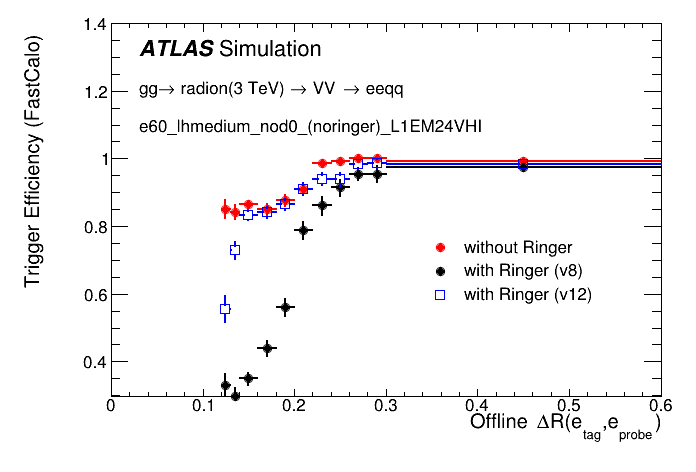

In [25]:
colors = [kRed, kBlack, kBlue, kBlue, kBlue]
markers = [20, 20, 25]
deltaRbins = [0.0,0.1, 0.12,0.13, 0.14, 0.16, 0.18,
              0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.6]
legends = ['without Ringer',
           'with Ringer (v8)',
           'with Ringer (v12)',
          ]
d = my_data.loc[ (my_data.el_TaP_deltaR > 0.12) ]


level='L2Calo'
hists = [
        get_profile(d, level+"_e60_lhmedium_nod0_noringer_L1EM24VHI"   , deltaRbins, 1, 55, 'el_lhmedium'),
        get_profile(d, level+"_e60_lhmedium_nod0_ringer_v8_L1EM24VHI"  , deltaRbins, 1, 55, 'el_lhmedium'),
        get_profile(d, level+"_e60_lhmedium_nod0_ringer_v12_L1EM24VHI" , deltaRbins, 1, 55, 'el_lhmedium'),
        ]

fig = rpl.create_canvas('my_canvas')
rpl.plot_profiles( hists, 'Offline #DeltaR(e_{tag},e_{probe})', colors, markers, ylabel='Trigger Efficiency (FastCalo)' )
rpl.set_atlas_label(0.2,0.88,'Simulation' )
rpl.add_text( 0.2, 0.80, 'gg#rightarrow radion(3 TeV)#rightarrow VV #rightarrow eeqq', textsize=0.04)
rpl.add_text( 0.2, 0.72, 'e60_lhmedium_nod0_(noringer)_L1EM24VHI', textsize=0.04)
add_legend( 0.6,0.35,legends )
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1.4) 
fig.show()
fig.savefig(output_path+'/eff_emu_mc16_e60_ringer_v12_L2Calo_deltaR.pdf')

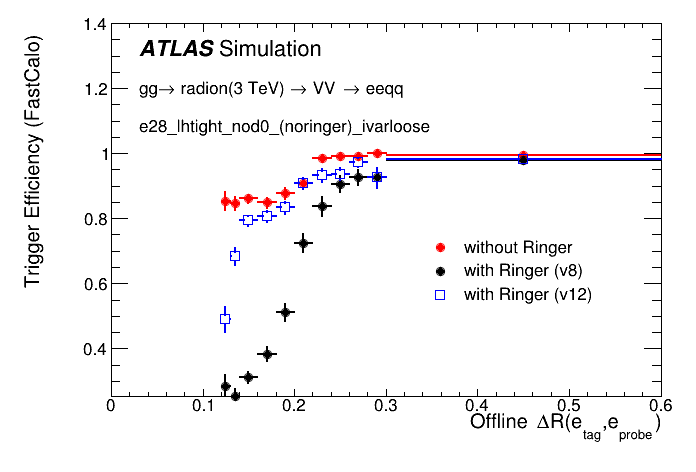

In [26]:
colors = [kRed, kBlack, kBlue, kBlue, kBlue]
markers = [20, 20, 25]
deltaRbins = [0.0,0.1, 0.12,0.13, 0.14, 0.16, 0.18,
              0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.6]
legends = ['without Ringer',
           'with Ringer (v8)',
           'with Ringer (v12)',
          ]
d = my_data.loc[ (my_data.el_TaP_deltaR > 0.12) ]


level='L2Calo'
hists = [
        get_profile(d, level+"_e28_lhtight_nod0_noringer_ivarloose"   ,deltaRbins, 1, 23, 'el_lhtight'),
        get_profile(d, level+"_e28_lhtight_nod0_ringer_v8_ivarloose"  ,deltaRbins, 1, 23, 'el_lhtight'),
        get_profile(d, level+"_e28_lhtight_nod0_ringer_v12_ivarloose" ,deltaRbins, 1, 23, 'el_lhtight'),


        ]

fig = rpl.create_canvas('my_canvas')
rpl.plot_profiles( hists, 'Offline #DeltaR(e_{tag},e_{probe})', colors, markers, ylabel='Trigger Efficiency (FastCalo)' )
rpl.set_atlas_label(0.2,0.88,'Simulation' )
rpl.add_text( 0.2, 0.80, 'gg#rightarrow radion(3 TeV)#rightarrow VV #rightarrow eeqq', textsize=0.04)
rpl.add_text( 0.2, 0.72, 'e28_lhtight_nod0_(noringer)_ivarloose', textsize=0.04)
add_legend( 0.6,0.35,legends )
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1.4) 
fig.show()
fig.savefig(output_path+'/eff_emu_mc16_e28_ringer_v12_L2Calo_deltaR.pdf')

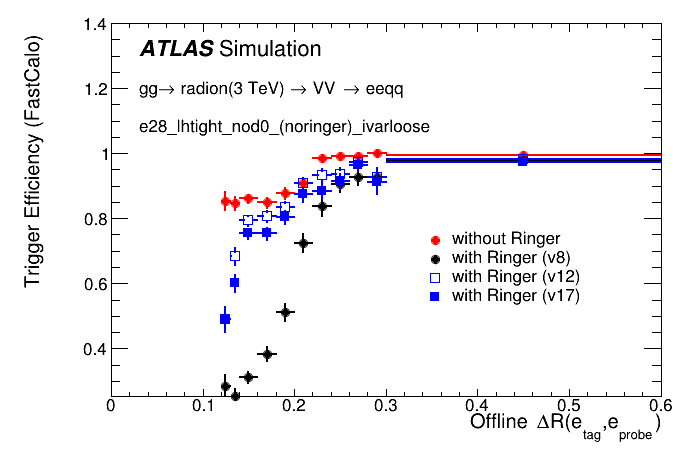

In [27]:
colors = [kRed, kBlack, kBlue, kBlue, kBlue]
markers = [20, 20, 25,21]
deltaRbins = [0.0,0.1, 0.12,0.13, 0.14, 0.16, 0.18,
              0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.6]
legends = ['without Ringer',
           'with Ringer (v8)',
           'with Ringer (v12)',
           'with Ringer (v17)',


          ]
d = my_data.loc[ (my_data.el_TaP_deltaR > 0.12) ]


level='L2'
hists = [
        get_profile(d, level+"_e28_lhtight_nod0_noringer_ivarloose"   ,deltaRbins, 1, 23, 'el_lhtight'),
        get_profile(d, level+"_e28_lhtight_nod0_ringer_v8_ivarloose"  ,deltaRbins, 1, 23, 'el_lhtight'),
        get_profile(d, level+"_e28_lhtight_nod0_ringer_v12_ivarloose" ,deltaRbins, 1, 23, 'el_lhtight'),
        get_profile(d, level+"_e28_lhtight_nod0_ringer_v17_ivarloose" ,deltaRbins, 1, 23, 'el_lhtight'),



        ]

fig = rpl.create_canvas('my_canvas')
rpl.plot_profiles( hists, 'Offline #DeltaR(e_{tag},e_{probe})', colors, markers, ylabel='Trigger Efficiency (FastCalo)' )
rpl.set_atlas_label(0.2,0.88,'Simulation' )
rpl.add_text( 0.2, 0.80, 'gg#rightarrow radion(3 TeV)#rightarrow VV #rightarrow eeqq', textsize=0.04)
rpl.add_text( 0.2, 0.72, 'e28_lhtight_nod0_(noringer)_ivarloose', textsize=0.04)
add_legend( 0.6,0.35,legends )
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1.4) 
fig.show()
fig.savefig(output_path+'/eff_emu_mc16_e28_ringer_v17_L2_deltaR.pdf')

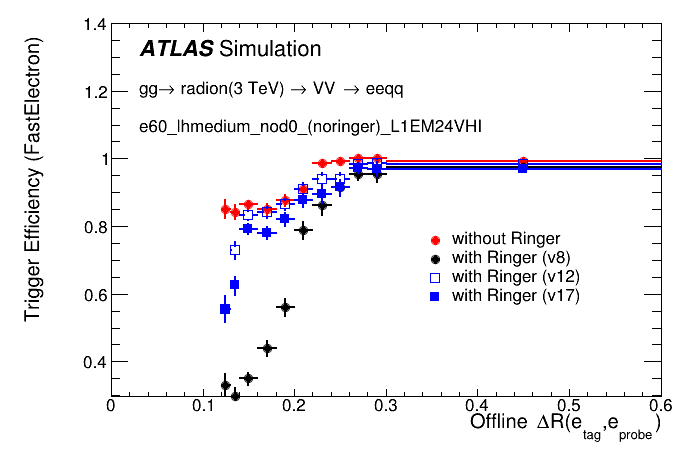

In [28]:
colors = [kRed, kBlack, kBlue, kBlue, kBlue]
markers = [20, 20, 25,21]
deltaRbins = [0.0,0.1, 0.12,0.13, 0.14, 0.16, 0.18,
              0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.6]
legends = ['without Ringer',
           'with Ringer (v8)',
           'with Ringer (v12)',
           'with Ringer (v17)',
          ]
d = my_data.loc[ (my_data.el_TaP_deltaR > 0.12) ]


level='L2'
hists = [
        get_profile(d, level+"_e60_lhmedium_nod0_noringer_L1EM24VHI"   , deltaRbins, 1, 55, 'el_lhmedium'),
        get_profile(d, level+"_e60_lhmedium_nod0_ringer_v8_L1EM24VHI"  , deltaRbins, 1, 55, 'el_lhmedium'),
        get_profile(d, level+"_e60_lhmedium_nod0_ringer_v12_L1EM24VHI" , deltaRbins, 1, 55, 'el_lhmedium'),
        get_profile(d, level+"_e60_lhmedium_nod0_ringer_v17_L1EM24VHI" , deltaRbins, 1, 55, 'el_lhmedium'),
        ]

fig = rpl.create_canvas('my_canvas')
rpl.plot_profiles( hists, 'Offline #DeltaR(e_{tag},e_{probe})', colors, markers, ylabel='Trigger Efficiency (FastElectron)' )
rpl.set_atlas_label(0.2,0.88,'Simulation' )
rpl.add_text( 0.2, 0.80, 'gg#rightarrow radion(3 TeV)#rightarrow VV #rightarrow eeqq', textsize=0.04)
rpl.add_text( 0.2, 0.72, 'e60_lhmedium_nod0_(noringer)_L1EM24VHI', textsize=0.04)
add_legend( 0.6,0.35,legends )
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1.4) 
fig.show()
fig.savefig(output_path+'/eff_emu_mc16_e60_ringer_v17_L2_deltaR.pdf')